# Recurrent Neural Network

In [129]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


def union(df1, df2):
    return pd.concat([df1, df2]).drop_duplicates().reset_index(drop=True)


def generate_time_lags(df, n_lags, column):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n[column].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n


def load_data(column, batch_size):
    # Load data
    train = pd.read_csv("Google_Stock_Price_Train.csv", parse_dates=["Date"], thousands=',')
    test = pd.read_csv("Google_Stock_Price_Test.csv", parse_dates=["Date"], thousands=',')

    # Merge training and testing and apply one hot encoding
    data = union(train, test)
    # Add month and day
    data["month"] = pd.DatetimeIndex(data["Date"]).month
    data["day"] = pd.DatetimeIndex(data["Date"]).day
    data = pd.get_dummies(data, columns=["month", "day"]).drop(columns=["Date"])
    
    data = data.iloc[565:]
    data = data.drop(columns=["Open", "High", "Low", "Volume"])
    data = generate_time_lags(data, 50, "Close").reset_index(drop=True)

    # Apply min-max scaler
    scaler = MinMaxScaler()
    scaler.fit(data)
    data = pd.DataFrame(scaler.transform(data), columns=data.columns)
    
    y = data[column].to_numpy()
    X = data.drop(columns=column).to_numpy()
    features = X.shape[1]

    # Split training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

    # Convert to tensor
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test)
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val)

    train = TensorDataset(X_train, y_train)
    test = TensorDataset(X_test, y_test)
    val = TensorDataset(X_val, y_val)

    trainloader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
    testloader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
    valloader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

    return trainloader, testloader, valloader, features

In [130]:
import torch.nn as nn
import torch.nn.functional as F


def get_model(model, **args):
    if model == "rnn":
        return RNN(**args)
    elif model == "lstm":
        return LSTM(**args)
    elif model == "gru":
        return GRU(**args)

In [131]:
class RNN(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.RNN(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [132]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.LSTM(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [133]:
class GRU(nn.Module):
    def __init__(self, hidden_dim, layer_dim, features, dropout):
        super(GRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.output_dim = 1

        self.rnn = nn.GRU(features, self.hidden_dim, self.layer_dim, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [134]:
import numpy as np
import matplotlib.pyplot as plt


def fit(rnn, trainloader, testloader, valloader, batch_size, criterion, optimizer, features):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    rnn.to(device)
    epoch_num = 200
    min_val = 1000
    n = 0
    train_losses = []
    val_losses = []
    for epoch in range(1, epoch_num + 1):  # loop over the dataset multiple times
        batch_losses = []
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.view([batch_size, -1, features]).to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            rnn.train()
            outputs = rnn(inputs)
            loss = criterion(labels, outputs)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_losses.append(np.mean(batch_losses))

        # Validation loss
        with torch.no_grad():
            batch_val_losses = []
            for inputs, labels in valloader:
                # get the inputs; data is a list of [inputs, labels]
                inputs = inputs.view([batch_size, -1, features]).to(device)
                labels = labels.to(device)

                # forward + backward + optimize
                rnn.eval()
                outputs = rnn(inputs)
                loss = criterion(labels, outputs)
                batch_val_losses.append(loss.item())

            val_losses.append(np.mean(batch_val_losses))

        if np.mean(batch_val_losses) < min_val:
            min_val = np.mean(batch_val_losses)
            n = 0
        else:
            n += 1
        if n == 5:
            #print(f"Epoch: {epoch}  Training Error: {np.mean(batch_losses):.4f}  Validation Error: {np.mean(batch_val_losses):.4f}")
            break
        #if epoch % 10 == 0:
        #    print(f"Epoch: {epoch}  Training Error: {np.mean(batch_losses):.4f}  Validation Error: {np.mean(batch_val_losses):.4f}")4

    #plt.yscale("log")
    #plt.plot(train_losses)
    #plt.plot(val_losses)

    train_prediction = []
    train_actual = []
    test_prediction = []
    test_actual = []
    for inputs, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.view([batch_size, -1, features]).to(device)
        labels = labels.to(device)
        
        rnn.eval()
        outputs = rnn(inputs)
        train_prediction.append(outputs.detach().numpy())
        train_actual.append(labels.detach().numpy())

    for inputs, labels in testloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.view([batch_size, -1, features]).to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        rnn.eval()
        outputs = rnn(inputs)
        test_prediction.append(outputs.detach().numpy())
        test_actual.append(labels.detach().numpy())

    train_prediction = np.array(train_prediction).flatten()
    train_actual = np.array(train_actual).flatten()
    test_prediction = np.array(test_prediction).flatten()
    test_actual = np.array(test_actual).flatten()

    return train_prediction, train_actual, test_prediction, test_actual


In [135]:
import seaborn as sns
sns.set()

def plot(prediction, actual):
    df = pd.DataFrame({"Predicted": prediction, "Actual": actual})
    sns.lineplot(data=df)

In [136]:
from sklearn.metrics import mean_squared_error, r2_score

def metrics(prediction, actual):
    r2 = r2_score(actual, prediction)
    rmse = mean_squared_error(actual, prediction, squared=False)

    print(f"R-squared: {r2:.4f}")
    print(f"Mean Square Error: {rmse:.4f}")
    return r2, rmse

In [137]:
import torch.optim as optim

hidden_dims = []
layer_dims = []
mean_r2_scores = []
sd_r2_scores = []
mean_rmse_scores = []
sd_rmse_scores = []
for hidden_dim in [10, 20, 30, 40, 50, 75, 100, 200]:
        for layer_dim in range(1, 4, 1):
                hidden_dims.append(hidden_dim)
                layer_dims.append(layer_dim)
                r2_scores = []
                rmse_scores = []
                for i in range(10):
                        column = "Close"
                        batch_size = 20

                        trainloader, testloader, valloader, features = load_data(column, batch_size)

                        # RNN hyperparamters
                        params = {"hidden_dim": hidden_dim,
                                "layer_dim": layer_dim,
                                "dropout": 0.2,
                                "features": features}

                        # rnn, lstm, gru
                        model = "lstm"
                        rnn = get_model(model, **params)

                        criterion = nn.MSELoss(reduction="mean")
                        optimizer = optim.Adam(rnn.parameters(), lr=0.001)

                        args = {"batch_size": batch_size,
                                "trainloader": trainloader,
                                "testloader": testloader,
                                "valloader": valloader,
                                "features": features,
                                "rnn": rnn,
                                "criterion": criterion,
                                "optimizer": optimizer}

                        train_prediction, train_actual, test_prediction, test_actual = fit(**args)
                        r2, rmse = metrics(test_prediction, test_actual)
                        r2_scores.append(r2)
                        rmse_scores.append(rmse)
                
                print(f"Mean R2: {np.mean(r2_scores):.4f} +- {np.std(r2_scores):.4f}")
                print(f"Mean RMSE: {np.mean(rmse_scores):.4f} +- {np.std(rmse_scores):.4f}")
                mean_r2_scores.append(np.mean(r2_scores))
                mean_rmse_scores.append(np.mean(rmse_scores))
                sd_r2_scores.append(np.std(r2_scores))
                sd_rmse_scores.append(np.std(rmse_scores))


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -18.6754
Mean Square Error: 0.1658


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -22.3342
Mean Square Error: 0.1806


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.4168
Mean Square Error: 0.1147


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.3884
Mean Square Error: 0.1145


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.8677
Mean Square Error: 0.1392


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.0594
Mean Square Error: 0.1351


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -13.8728
Mean Square Error: 0.1441


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -13.6354
Mean Square Error: 0.1430


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.5338
Mean Square Error: 0.1269


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.5796
Mean Square Error: 0.0883
Mean R2: -12.5363 +- 4.8838
Mean RMSE: 0.1352 +- 0.0250


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.8809
Mean Square Error: 0.1393


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -17.0182
Mean Square Error: 0.1587


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -14.3373
Mean Square Error: 0.1464


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -17.8994
Mean Square Error: 0.1625


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -15.8051
Mean Square Error: 0.1532


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -20.1063
Mean Square Error: 0.1717


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -15.8656
Mean Square Error: 0.1535


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -17.7196
Mean Square Error: 0.1617


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.2900
Mean Square Error: 0.1363


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -18.1209
Mean Square Error: 0.1634
Mean R2: -16.2043 +- 2.3422
Mean RMSE: 0.1547 +- 0.0107


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -25.0944
Mean Square Error: 0.1909


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -19.8477
Mean Square Error: 0.1707


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -19.2758
Mean Square Error: 0.1683


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -19.1914
Mean Square Error: 0.1680


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -23.8194
Mean Square Error: 0.1862


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -20.4643
Mean Square Error: 0.1732


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -25.0870
Mean Square Error: 0.1909


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -26.6179
Mean Square Error: 0.1964


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -26.8159
Mean Square Error: 0.1971


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -24.0993
Mean Square Error: 0.1873
Mean R2: -23.0313 +- 2.8810
Mean RMSE: 0.1829 +- 0.0111


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -14.9522
Mean Square Error: 0.1493


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.4108
Mean Square Error: 0.1147


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.2998
Mean Square Error: 0.0775


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.9787
Mean Square Error: 0.1120


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -13.2834
Mean Square Error: 0.1413


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.7003
Mean Square Error: 0.0968


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.9639
Mean Square Error: 0.0913


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.3410
Mean Square Error: 0.0864


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.1599
Mean Square Error: 0.0849


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.8874
Mean Square Error: 0.1175
Mean R2: -7.5977 +- 3.7459
Mean RMSE: 0.1072 +- 0.0230


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.1644
Mean Square Error: 0.1192


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.5168
Mean Square Error: 0.1212


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.8138
Mean Square Error: 0.1110


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.4560
Mean Square Error: 0.1265


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -14.8900
Mean Square Error: 0.1490


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.1092
Mean Square Error: 0.1188


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.6013
Mean Square Error: 0.0885


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -14.5595
Mean Square Error: 0.1474


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.6069
Mean Square Error: 0.1217


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.6847
Mean Square Error: 0.1278
Mean R2: -10.0402 +- 2.8490
Mean RMSE: 0.1231 +- 0.0164


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -14.5593
Mean Square Error: 0.1474


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -13.7471
Mean Square Error: 0.1435


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -13.8601
Mean Square Error: 0.1441


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -11.3456
Mean Square Error: 0.1313


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -16.1093
Mean Square Error: 0.1546


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -19.9666
Mean Square Error: 0.1712


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -16.4416
Mean Square Error: 0.1561


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -14.3653
Mean Square Error: 0.1465


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -14.1141
Mean Square Error: 0.1453


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -16.8087
Mean Square Error: 0.1577
Mean R2: -15.1318 +- 2.2063
Mean RMSE: 0.1498 +- 0.0102


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.8724
Mean Square Error: 0.0906


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.8734
Mean Square Error: 0.1049


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.4905
Mean Square Error: 0.0698


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0188
Mean Square Error: 0.1123


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.8055
Mean Square Error: 0.0975


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.0735
Mean Square Error: 0.1351


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.4346
Mean Square Error: 0.0871


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.0556
Mean Square Error: 0.1243


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.7010
Mean Square Error: 0.1164


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.8139
Mean Square Error: 0.1171
Mean R2: -7.2139 +- 2.7336
Mean RMSE: 0.1055 +- 0.0185


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.0188
Mean Square Error: 0.0990


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.0235
Mean Square Error: 0.0838


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0737
Mean Square Error: 0.1126


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.8474
Mean Square Error: 0.1047


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.7065
Mean Square Error: 0.1279


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.3506
Mean Square Error: 0.0942


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.7956
Mean Square Error: 0.1109


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.0974
Mean Square Error: 0.0923


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.5039
Mean Square Error: 0.1374


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.2297
Mean Square Error: 0.1005
Mean R2: -7.2647 +- 2.4879
Mean RMSE: 0.1063 +- 0.0156


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -17.6475
Mean Square Error: 0.1614


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -14.9628
Mean Square Error: 0.1493


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.4658
Mean Square Error: 0.1372


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.7542
Mean Square Error: 0.1386


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -15.2924
Mean Square Error: 0.1509


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.8322
Mean Square Error: 0.1286


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -14.4262
Mean Square Error: 0.1468


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.0326
Mean Square Error: 0.1184


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -13.3104
Mean Square Error: 0.1414


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.6269
Mean Square Error: 0.1380
Mean R2: -13.3351 +- 2.2943
Mean RMSE: 0.1411 +- 0.0115


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.8070
Mean Square Error: 0.0820


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.5841
Mean Square Error: 0.1216


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.5028
Mean Square Error: 0.1268


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.2490
Mean Square Error: 0.1137


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.5274
Mean Square Error: 0.0795


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.8109
Mean Square Error: 0.1389


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.7293
Mean Square Error: 0.1039


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.4433
Mean Square Error: 0.0449


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.3152
Mean Square Error: 0.1011


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.1181
Mean Square Error: 0.0544
Mean R2: -6.3087 +- 3.8714
Mean RMSE: 0.0967 +- 0.0294


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.8083
Mean Square Error: 0.1171


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.6322
Mean Square Error: 0.0606


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.1655
Mean Square Error: 0.0665


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.5171
Mean Square Error: 0.0954


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.6372
Mean Square Error: 0.0805


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.9231
Mean Square Error: 0.0983


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.4336
Mean Square Error: 0.0787


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.5906
Mean Square Error: 0.0960


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.1666
Mean Square Error: 0.0928


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.7700
Mean Square Error: 0.0622
Mean R2: -4.3644 +- 2.1466
Mean RMSE: 0.0848 +- 0.0174


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.8172
Mean Square Error: 0.1171


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.8821
Mean Square Error: 0.1233


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.9977
Mean Square Error: 0.1295


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.1521
Mean Square Error: 0.1067


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.8197
Mean Square Error: 0.1285


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.8325
Mean Square Error: 0.1230


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.4454
Mean Square Error: 0.1208


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.5336
Mean Square Error: 0.1213


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0784
Mean Square Error: 0.1126


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0340
Mean Square Error: 0.1123
Mean R2: -9.2593 +- 1.1754
Mean RMSE: 0.1195 +- 0.0069


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.2245
Mean Square Error: 0.0768


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.3582
Mean Square Error: 0.0436


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.1658
Mean Square Error: 0.0404


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.1273
Mean Square Error: 0.1247


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.1860
Mean Square Error: 0.0407


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: 0.1747
Mean Square Error: 0.0340


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.7447
Mean Square Error: 0.0494


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.6488
Mean Square Error: 0.0806


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.6244
Mean Square Error: 0.0606


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.1299
Mean Square Error: 0.0397
Mean R2: -2.0035 +- 2.9927
Mean RMSE: 0.0590 +- 0.0267


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.5913
Mean Square Error: 0.0708


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.7290
Mean Square Error: 0.0813


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.4142
Mean Square Error: 0.1084


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.1267
Mean Square Error: 0.0846


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.3272
Mean Square Error: 0.0682


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.6601
Mean Square Error: 0.0889


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.8072
Mean Square Error: 0.1229


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.5193
Mean Square Error: 0.1153


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.7123
Mean Square Error: 0.0893


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.4216
Mean Square Error: 0.1085
Mean R2: -5.5309 +- 2.4473
Mean RMSE: 0.0938 +- 0.0179


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.4327
Mean Square Error: 0.1264


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.4761
Mean Square Error: 0.1151


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.5703
Mean Square Error: 0.1028


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.2282
Mean Square Error: 0.1195


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -10.8287
Mean Square Error: 0.1286


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.2749
Mean Square Error: 0.0936


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.6167
Mean Square Error: 0.1218


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.4455
Mean Square Error: 0.1086


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.7554
Mean Square Error: 0.1167


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.9050
Mean Square Error: 0.1234
Mean R2: -8.6534 +- 1.6726
Mean RMSE: 0.1157 +- 0.0105


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.1581
Mean Square Error: 0.0664


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: 0.0693
Mean Square Error: 0.0361


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.4193
Mean Square Error: 0.0445


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: 0.0520
Mean Square Error: 0.0364


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.9771
Mean Square Error: 0.0834


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: 0.1333
Mean Square Error: 0.0348


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.4948
Mean Square Error: 0.0876


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.5105
Mean Square Error: 0.0592


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.7273
Mean Square Error: 0.0491


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.3560
Mean Square Error: 0.0435
Mean R2: -1.3388 +- 1.6091
Mean RMSE: 0.0541 +- 0.0184


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.2082
Mean Square Error: 0.0411


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.4073
Mean Square Error: 0.0443


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.4422
Mean Square Error: 0.0584


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.0813
Mean Square Error: 0.0539


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.5065
Mean Square Error: 0.0459


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.1727
Mean Square Error: 0.0405


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: 0.1235
Mean Square Error: 0.0350


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -12.8304
Mean Square Error: 0.1390


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.5922
Mean Square Error: 0.1158


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.8122
Mean Square Error: 0.0976
Mean R2: -3.0930 +- 4.2465
Mean RMSE: 0.0671 +- 0.0348


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.9498
Mean Square Error: 0.1054


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.8075
Mean Square Error: 0.0729


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.2147
Mean Square Error: 0.1004


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.4711
Mean Square Error: 0.0874


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.7540
Mean Square Error: 0.1041


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.3995
Mean Square Error: 0.0946


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.5246
Mean Square Error: 0.0955


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0199
Mean Square Error: 0.1123


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.6658
Mean Square Error: 0.1162


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.3463
Mean Square Error: 0.1013
Mean R2: -6.1153 +- 1.6064
Mean RMSE: 0.0990 +- 0.0118


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.3702
Mean Square Error: 0.0438


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.5541
Mean Square Error: 0.0705


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.1593
Mean Square Error: 0.0402


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: 0.0081
Mean Square Error: 0.0372


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.4260
Mean Square Error: 0.0446


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.0192
Mean Square Error: 0.0531


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.2703
Mean Square Error: 0.0421


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.4594
Mean Square Error: 0.0695


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.7842
Mean Square Error: 0.0499


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.4749
Mean Square Error: 0.0454
Mean R2: -0.8509 +- 0.8733
Mean RMSE: 0.0496 +- 0.0110


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.9834
Mean Square Error: 0.1056


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.6500
Mean Square Error: 0.0714


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.6684
Mean Square Error: 0.0716


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.2636
Mean Square Error: 0.0772


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.3974
Mean Square Error: 0.0442


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.2323
Mean Square Error: 0.0415


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.0907
Mean Square Error: 0.0390


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.7548
Mean Square Error: 0.0971


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.1745
Mean Square Error: 0.0405


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: 0.0820
Mean Square Error: 0.0358
Mean R2: -2.2133 +- 2.4073
Mean RMSE: 0.0624 +- 0.0244


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.0834
Mean Square Error: 0.1127


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -27.5368
Mean Square Error: 0.1997


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.9450
Mean Square Error: 0.1054


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.7310
Mean Square Error: 0.0970


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.5284
Mean Square Error: 0.0955


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.3928
Mean Square Error: 0.1205


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.3201
Mean Square Error: 0.0862


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -61.7489
Mean Square Error: 0.2961


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.2536
Mean Square Error: 0.0935


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.5551
Mean Square Error: 0.1027
Mean R2: -14.1095 +- 17.1314
Mean RMSE: 0.1309 +- 0.0630


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.8547
Mean Square Error: 0.0509


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.2548
Mean Square Error: 0.0771


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.2109
Mean Square Error: 0.0670


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.1665
Mean Square Error: 0.0404


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.5777
Mean Square Error: 0.0600


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.0711
Mean Square Error: 0.0655


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.6037
Mean Square Error: 0.0802


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.4234
Mean Square Error: 0.0446


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -5.5799
Mean Square Error: 0.0959


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.0851
Mean Square Error: 0.0995
Mean R2: -2.5828 +- 1.9401
Mean RMSE: 0.0681 +- 0.0192


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.6513
Mean Square Error: 0.0609


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -2.6471
Mean Square Error: 0.0714


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -4.5083
Mean Square Error: 0.0877


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -25.4810
Mean Square Error: 0.1923


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -0.9643
Mean Square Error: 0.0524


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -17.7367
Mean Square Error: 0.1618


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.6835
Mean Square Error: 0.0612


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.3741
Mean Square Error: 0.0576


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.5684
Mean Square Error: 0.1215


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -3.9019
Mean Square Error: 0.0828
Mean R2: -6.9517 +- 7.8937
Mean RMSE: 0.0950 +- 0.0457


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.7315
Mean Square Error: 0.1224


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.2509
Mean Square Error: 0.1197


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.3703
Mean Square Error: 0.1015


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -9.8604
Mean Square Error: 0.1232


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -1.8521
Mean Square Error: 0.0631


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -14.3305
Mean Square Error: 0.1464


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -13.2529
Mean Square Error: 0.1411


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -7.3686
Mean Square Error: 0.1081


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -8.6453
Mean Square Error: 0.1161


C:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


R-squared: -6.5495
Mean Square Error: 0.1027
Mean R2: -8.7212 +- 3.3744
Mean RMSE: 0.1144 +- 0.0221


In [138]:
print(f"Mean R2: {np.mean(r2_scores):.4f} +- {np.std(r2_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} +- {np.std(rmse_scores):.4f}")

Mean R2: -8.7212 +- 3.3744
Mean RMSE: 0.1144 +- 0.0221


In [139]:
results = pd.DataFrame({
    "Hidden": hidden_dims,
    "Layer": layer_dims,
    "Mean R2": mean_r2_scores,
    "Sd R2": sd_r2_scores,
    "Mean RMSE": mean_rmse_scores,
    "Sd RMSE": sd_rmse_scores
})
results

,Hidden,Layer,Mean R2,Sd R2,Mean RMSE,Sd RMSE
0,10,1,-12.536343,4.883797,0.135223,0.025033
1,10,2,-16.204329,2.342165,0.154668,0.010691
2,10,3,-23.031319,2.881037,0.182899,0.011068
3,20,1,-7.597732,3.745926,0.107158,0.023004
4,20,2,-10.040244,2.848963,0.123111,0.016378
5,20,3,-15.131761,2.206333,0.149783,0.010154
6,30,1,-7.213919,2.733631,0.105513,0.018513
7,30,2,-7.264705,2.487892,0.106319,0.015588
8,30,3,-13.335100,2.294324,0.141055,0.011456
9,40,1,-6.308706,3.871403,0.096675,0.029410


R-squared: 0.9105
Mean Square Error: 0.0769


(0.9104694373393649, 0.07689907)

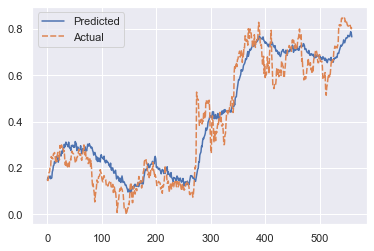

In [140]:
plot(train_prediction, train_actual)
metrics(train_prediction, train_actual)

R-squared: -6.5495
Mean Square Error: 0.1027


(-6.549473125989437, 0.10270094)

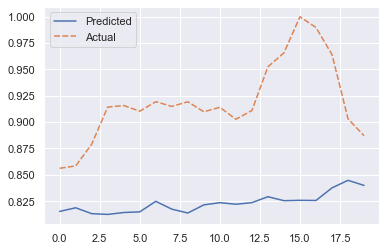

In [141]:
plot(test_prediction, test_actual)
metrics(test_prediction, test_actual)